K-Nearest Neighbors Model for Building Destruction Classification

In [19]:
#Import some basic packages
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style("whitegrid")


We start by reading data in from the cal_fire_data_cleaned CSV file:

In [20]:
#Let's import the data and instantiate a train/test split with the seed everyone is using.

cal_fire_data = pd.read_csv('../data/cal_fire_data_cleaned.csv')
cal_fire_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42789 entries, 0 to 42788
Data columns (total 15 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   * Structure Type                             42789 non-null  object 
 1   * Roof Construction                          42789 non-null  object 
 2   * Eaves                                      42789 non-null  object 
 3   * Vent Screen                                42789 non-null  object 
 4   * Exterior Siding                            42789 non-null  object 
 5   * Window Pane                                42789 non-null  object 
 6   * Deck/Porch On Grade                        42789 non-null  object 
 7   * Deck/Porch Elevated                        42789 non-null  object 
 8   * Patio Cover/Carport Attached to Structure  42789 non-null  object 
 9   * Fence Attached to Structure                42789 non-null  object 
 10

We create a train/test split (80%/20%):

In [21]:

from sklearn.model_selection import train_test_split
fire_train,fire_test = train_test_split(cal_fire_data, test_size=.2, random_state=216, shuffle=True, stratify=cal_fire_data['Destroyed'])
fire_train['Destroyed'].value_counts(normalize=True)


Destroyed
0    0.597616
1    0.402384
Name: proportion, dtype: float64

In [22]:
#Let's import all the functions from sklearn that we're using.

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score


We create a pipeline for one-hot encoding the categorical variables, scaling the numeric variables, and running a K-nearest neighbors model. Based on our exploration and parameter tuning, we choose k = 4 neighbors and all the variables but Age and AIV.

In [23]:
preprocessor = ColumnTransformer(
    transformers=[
        ("Structure Type", OneHotEncoder(), ['* Structure Type']),
        ("Roof Construction", OneHotEncoder(), ['* Roof Construction']),
        ("Eaves", OneHotEncoder(), ['* Eaves']),
        ("Vent Screen", OneHotEncoder(), ['* Vent Screen']),
        ("Exterior Siding", OneHotEncoder(), ['* Exterior Siding']),
        ("Window Pane", OneHotEncoder(), ['* Window Pane']),
        ("Elevated", OneHotEncoder(), ['* Deck/Porch Elevated']),
        ("Patio Cover/Carport Attached", OneHotEncoder(), ['* Patio Cover/Carport Attached to Structure']),
        ("Fence Attached to Structure", OneHotEncoder(), ['* Fence Attached to Structure']),
        ("Longitude", StandardScaler(), ['Longitude']),
        ("Latitude", StandardScaler(), ['Latitude'])
        ])

KNNmodel = Pipeline([('Preprocess', preprocessor), ('KNN', KNeighborsClassifier(4))])
KNNmodel.fit(fire_train[['* Structure Type', '* Roof Construction', '* Eaves', '* Vent Screen',
       '* Exterior Siding', '* Window Pane', '* Deck/Porch On Grade',
       '* Deck/Porch Elevated', '* Patio Cover/Carport Attached to Structure',
       '* Fence Attached to Structure', 'Latitude', 'Longitude']],fire_train['Destroyed'])


Pipeline(steps=[('Preprocess',
                 ColumnTransformer(transformers=[('Structure Type',
                                                  OneHotEncoder(),
                                                  ['* Structure Type']),
                                                 ('Roof Construction',
                                                  OneHotEncoder(),
                                                  ['* Roof Construction']),
                                                 ('Eaves', OneHotEncoder(),
                                                  ['* Eaves']),
                                                 ('Vent Screen',
                                                  OneHotEncoder(),
                                                  ['* Vent Screen']),
                                                 ('Exterior Siding',
                                                  OneHotEncoder(),
                                                  ['* Exterior Siding']),
                                                 ('Window Pane',
                                                  OneHotEncoder(),
                                                  ['* Wind...
                                                 ('Elevated', OneHotEncoder(),
                                                  ['* Deck/Porch Elevated']),
                                                 ('Patio Cover/Carport '
                                                  'Attached',
                                                  OneHotEncoder(),
                                                  ['* Patio Cover/Carport '
                                                   'Attached to Structure']),
                                                 ('Fence Attached to Structure',
                                                  OneHotEncoder(),
                                                  ['* Fence Attached to '
                                                   'Structure']),
                                                 ('Longitude', StandardScaler(),
                                                  ['Longitude']),
                                                 ('Latitude', StandardScaler(),
                                                  ['Latitude'])])),
                ('KNN', KNeighborsClassifier(n_neighbors=4))])

Along with the prediction accuracy, we have a classification report that includes precision, recall, and f1 scores:

In [24]:
#Let's look at some metrics.

y_pred = KNNmodel.predict(fire_test[['* Structure Type', '* Roof Construction', '* Eaves', '* Vent Screen',
       '* Exterior Siding', '* Window Pane', '* Deck/Porch On Grade',
       '* Deck/Porch Elevated', '* Patio Cover/Carport Attached to Structure',
       '* Fence Attached to Structure', 'Latitude', 'Longitude']])

print("accuracy: ", accuracy_score(fire_test.Destroyed, y_pred))
print("\nreport: \n")
print(classification_report(fire_test.Destroyed, y_pred))



accuracy:  0.8615330684739425

report: 

              precision    recall  f1-score   support

           0       0.85      0.93      0.89      5115
           1       0.88      0.76      0.82      3443

    accuracy                           0.86      8558
   macro avg       0.86      0.85      0.85      8558
weighted avg       0.86      0.86      0.86      8558



We also have a confusion matrix showing how the model performed across classes:

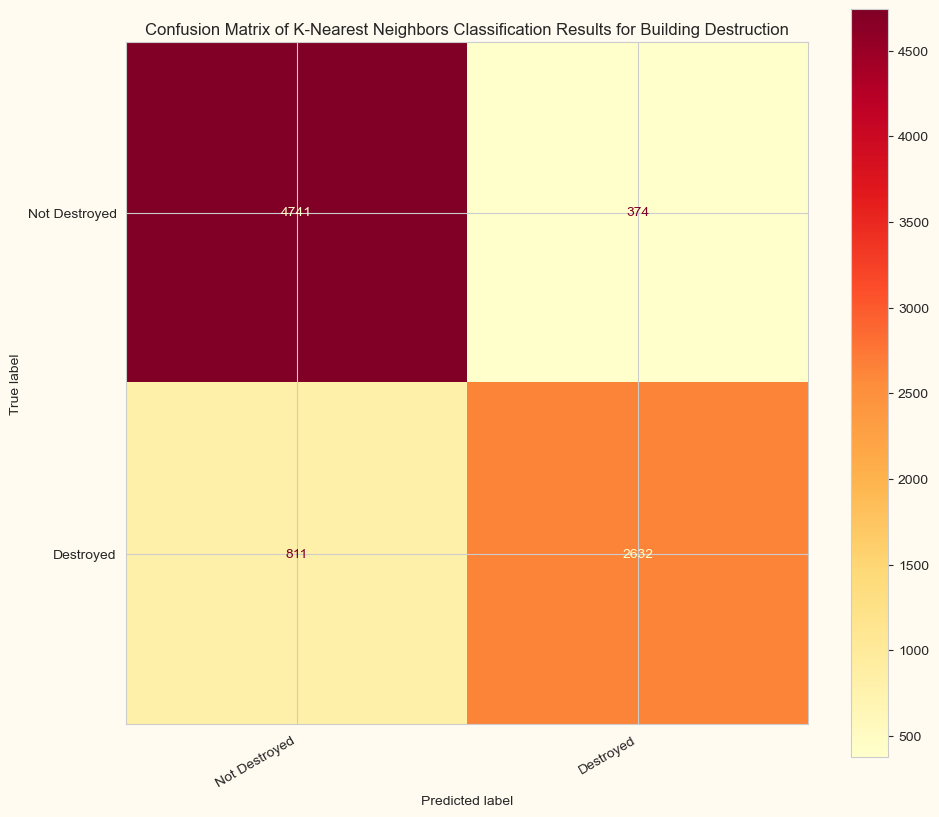

In [25]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(fire_test.Destroyed, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Destroyed', 'Destroyed'])
fig, ax = plt.subplots(figsize=(11, 11), facecolor = ('#fffbf0'))
disp.plot(ax=ax, cmap='YlOrRd')
fig.autofmt_xdate()
plt.title("Confusion Matrix of K-Nearest Neighbors Classification Results for Building Destruction")
plt.show()
